# Character Interactions Graphs



Step-by-Step Process
1. Text Preprocessing

Goal: Clean and prepare the raw text for analysis
Process:

Load each book's text file
Remove Project Gutenberg headers and footers
Convert all text to lowercase for consistency
Tokenize: Split text into individual words using regex pattern [a-z]+(?:'[a-z]+)?
This creates a sequential list of words maintaining their order in the story



2. Character Recognition

Goal: Identify every mention of tracked characters
Method:

Use a character dictionary with aliases (e.g., "Aragorn" = ["aragorn", "strider", "elessar"])
Scan through tokens and mark positions where character names appear
Map aliases back to canonical character names
Record both the position (word index) and character name



3. Proximity-Based Interaction Detection

Goal: Determine when two characters "interact" in the narrative
Core Assumption: If two different character names appear within a small window of text, they're likely interacting or in the same scene
Parameters:

Window Size: 15 words (configurable)
This captures dialogue, action sequences, and scene descriptions


Process:

For each character mention at position i
Look ahead at the next character mentions
If another character appears within 15 words, record an interaction
Stop checking once beyond the window size (optimization)



4. Edge Construction (Undirected Graph)

Why Undirected: Relationships are mutual—if Frodo interacts with Sam, Sam interacts with Frodo
Edge Weight: Count of how many times two characters appear near each other
Key Detail: Edges are stored as sorted pairs (e.g., "Aragorn-Frodo" not "Frodo-Aragorn") to avoid duplicates
Result: A dictionary where {("CharA", "CharB"): 145} means they co-occurred 145 times

5. Network Filtering

Challenge: Too many weak connections create cluttered visualizations
Solution: Select only the top N strongest connections

Fellowship: 39 edges
Two Towers: 30 edges
Return of the King: 35 edges


Effect: Focuses on the most significant relationships while maintaining clarity

6. Visual Encoding
Node Properties

Size: Proportional to weighted degree (number and strength of connections)

Characters with many strong relationships appear larger
Formula: Base size (2000) + scaled degree (up to 3000)
This highlights central characters like Frodo, Sam, Gandalf



Edge Properties

Width: Proportional to interaction frequency

Thicker lines = more co-occurrences
Formula: Base width (1.0) + scaled weight (up to 8.0)
Makes dominant relationships immediately visible


Color & Style:

Each book has distinct color scheme for aesthetic differentiation
Edge transparency (alpha=0.6) prevents visual overload



Layout Algorithm

Spring Layout (Force-Directed):

Treats nodes as charged particles that repel each other
Edges act like springs pulling connected nodes together
Parameter k=2.5: Controls ideal distance between nodes
Result: Strongly connected characters cluster together; peripheral characters spread out
100 iterations ensure stable layout



7. Special Adjustments

Frodo-Sam Overlap Fix (Return of the King only):

Problem: Their extremely high interaction count can cause overlap in layout
Solution: Detect if distance < 0.25 units, then manually push them apart
Maintains visual clarity without distorting overall network structure




Interpretation Guide
What the Network Shows:

Node Size → Character importance/centrality in the narrative
Edge Thickness → Strength/frequency of relationship
Spatial Proximity → Characters who interact with similar groups cluster together
Edge Labels → Exact co-occurrence counts for quantitative analysis

What It Reveals:

Fellowship Structure: Tight-knit traveling party
Narrative Splits: Two Towers shows diverging storylines (Frodo/Sam vs. Aragorn/Legolas/Gimli)
Evolving Relationships: New connections form as the story progresses
Character Roles: Central nodes are protagonists; peripheral nodes are supporting characters

# The code

Processing The Fellowship of the Ring...


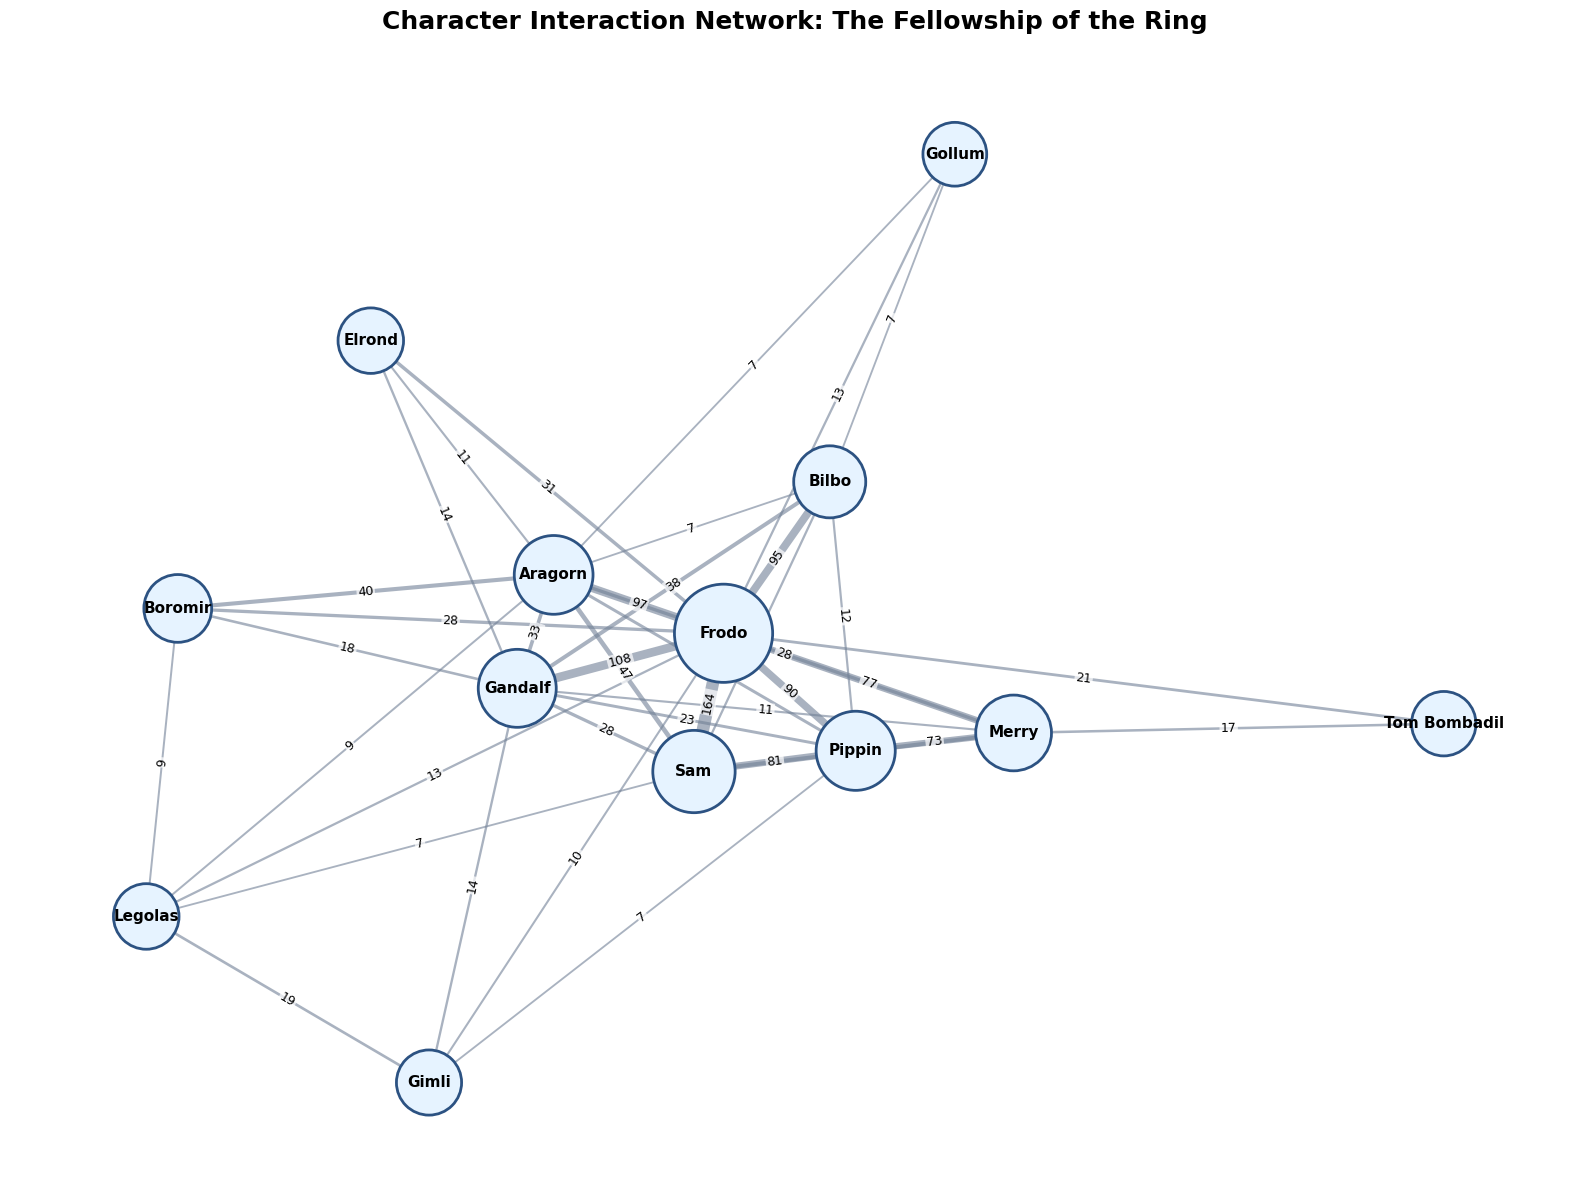

Processing The Two Towers...


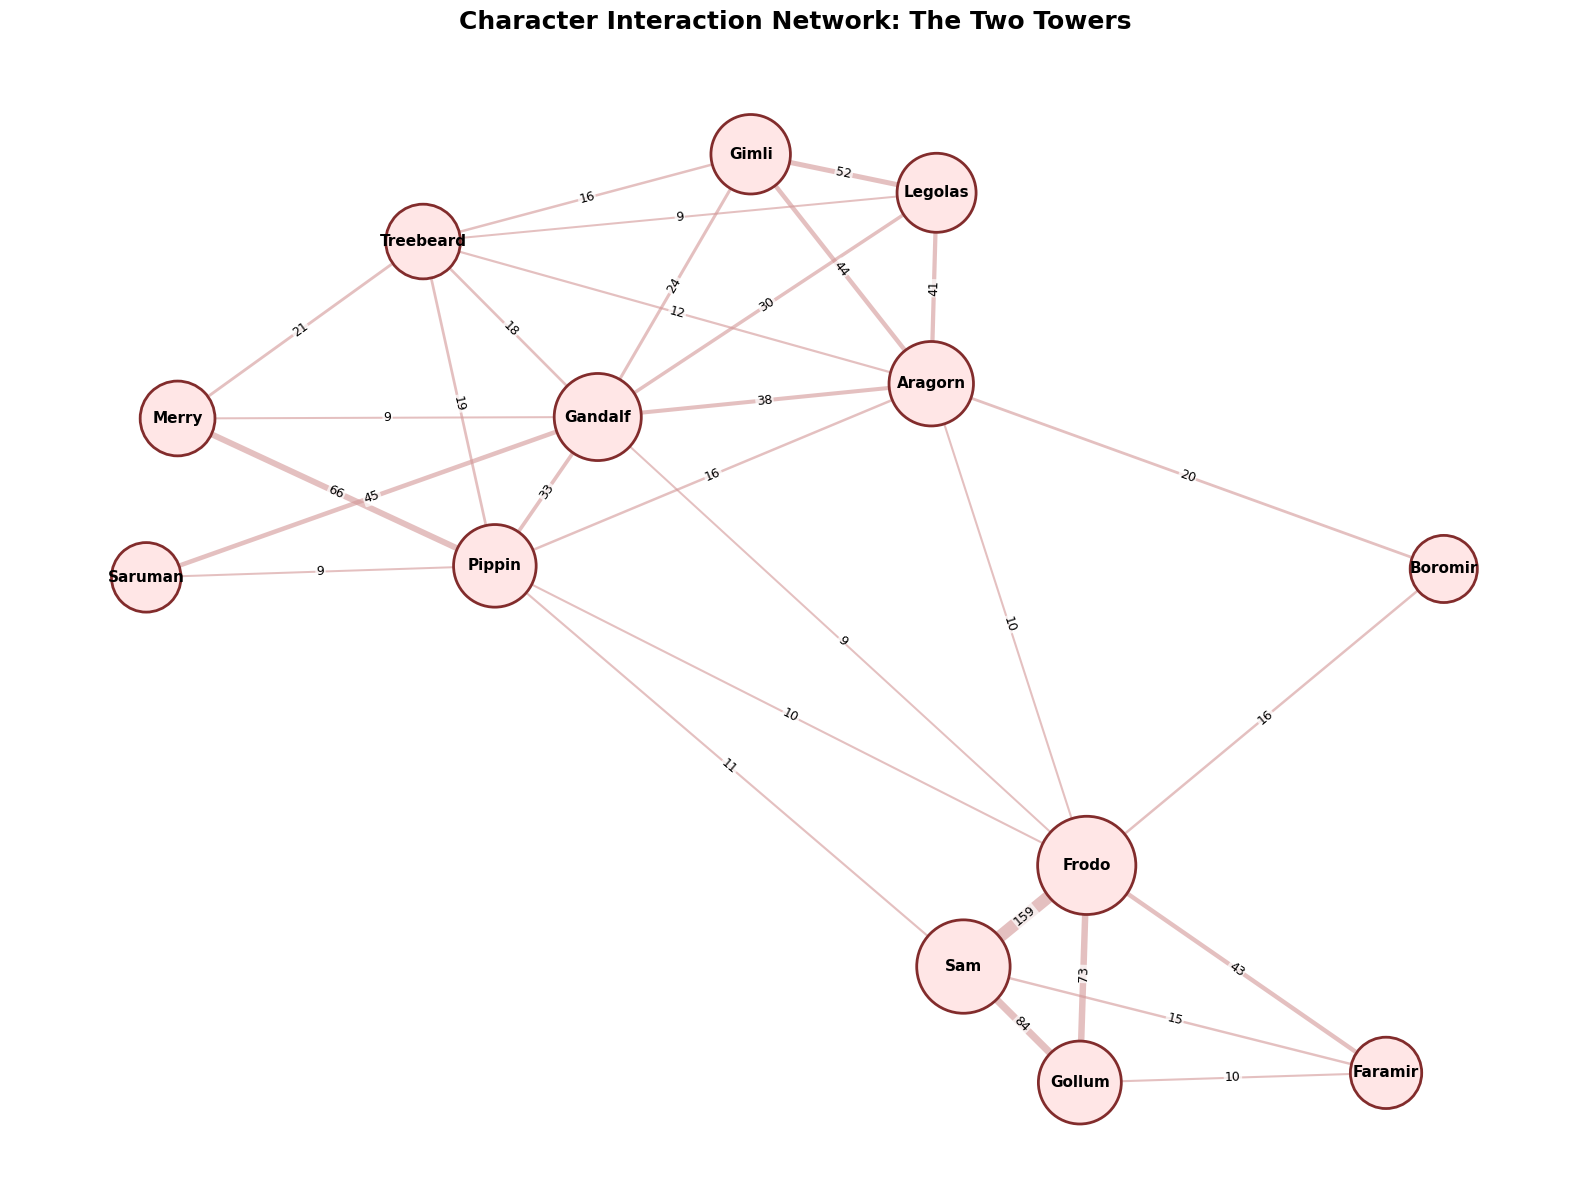

Processing The Return of the King...


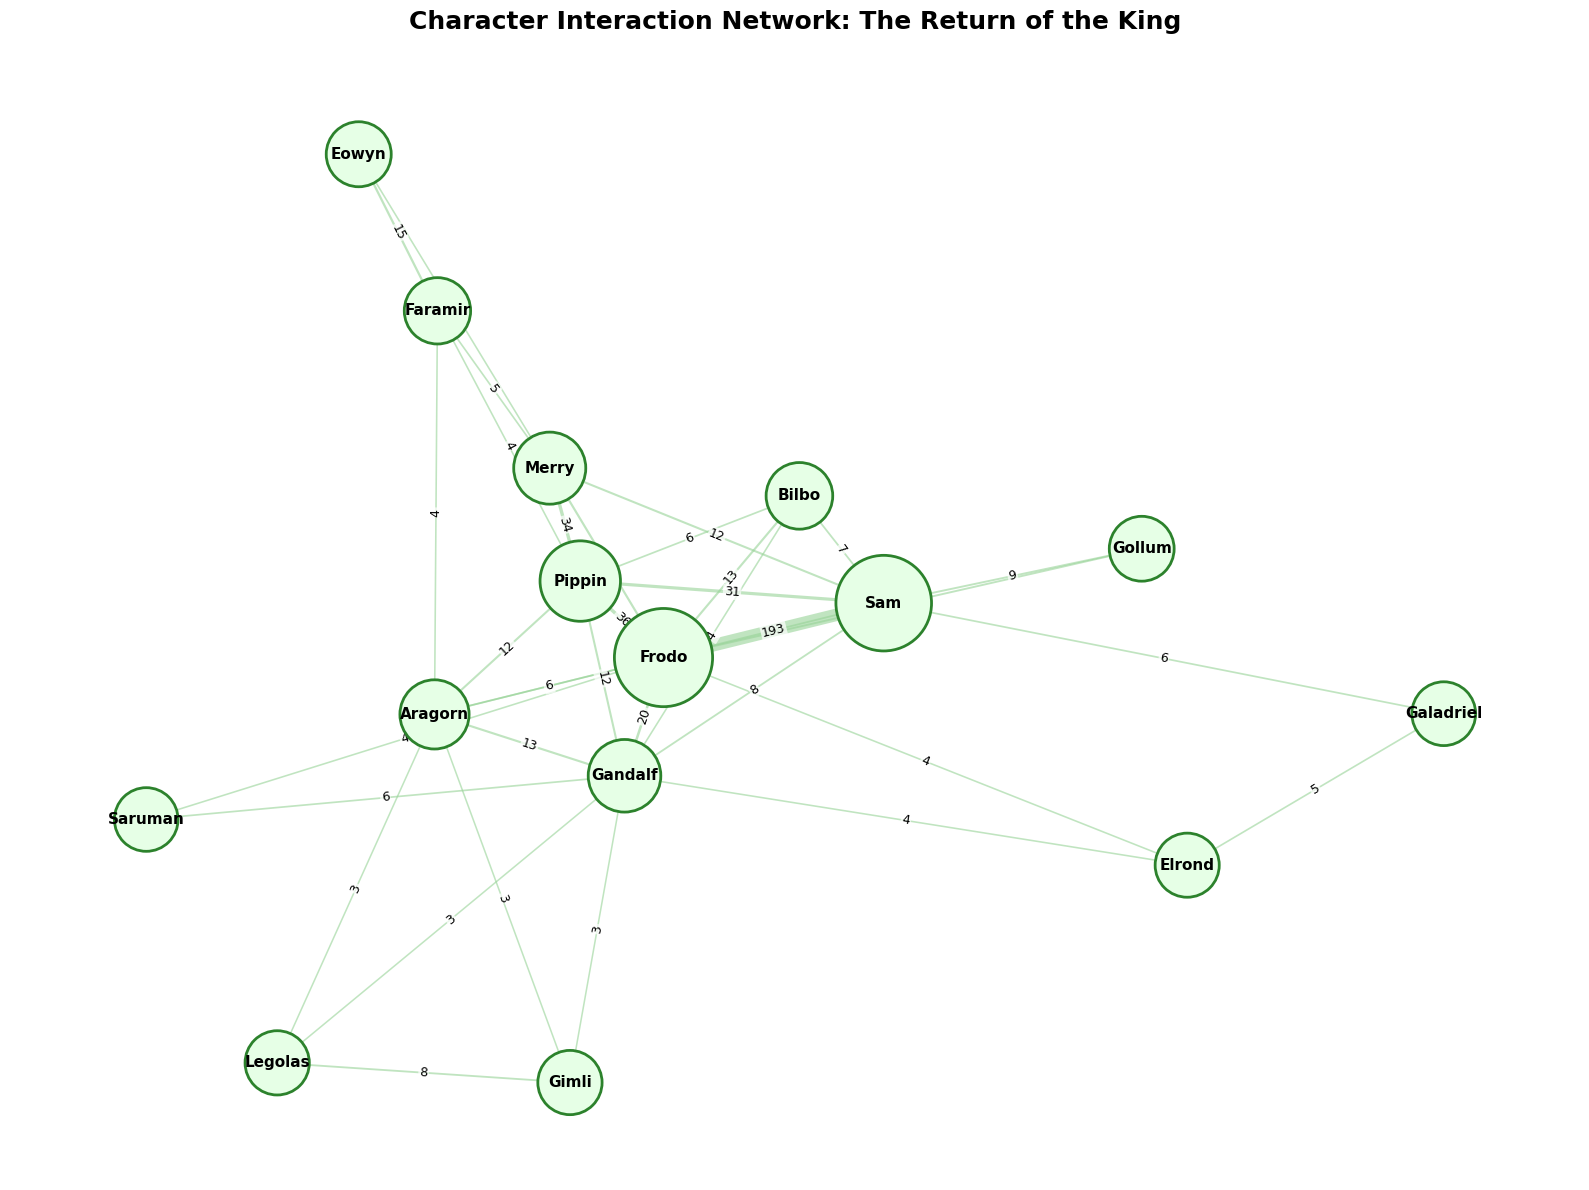

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import itertools
import numpy as np

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING (Same as before for consistency) ---
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"],
    "Arwen": ["arwen"],
    "Bilbo": ["bilbo"],
    "Tom Bombadil": ["tom", "bombadil"],
    "Treebeard": ["treebeard", "fangorn"],
    "Shelob": ["shelob"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- DATA LOADING AND PROCESSING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

def extract_interactions(tokens, alias_map, window_size=15):
    """
    Scans tokens. If two characters appear within 'window_size' words of each other,
    it counts as an interaction.
    Returns an UNDIRECTED edge dictionary: {(CharA, CharB): count}
    where CharA < CharB alphabetically to ensure single edges.
    """
    edges = defaultdict(int)
    
    # Identify character positions
    char_positions = []
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_positions.append((i, alias_map[word]))
            
    # Check distances
    for i in range(len(char_positions)):
        pos1, char1 = char_positions[i]
        for j in range(i + 1, len(char_positions)):
            pos2, char2 = char_positions[j]
            
            if pos2 - pos1 > window_size:
                break # Optimization: sorted by position, so we can stop early
            
            if char1 != char2:
                # Sort names to ensure undirected edge key (A, B) == (B, A)
                u, v = sorted([char1, char2])
                edges[(u, v)] += 1
                
    return edges

def adjust_frodo_sam_position(pos, min_distance=0.25):
    """
    Specifically adjusts Frodo and Sam to prevent overlap.
    """
    if "Frodo" in pos and "Sam" in pos:
        x1, y1 = pos["Frodo"]
        x2, y2 = pos["Sam"]
        
        dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        if dist < min_distance and dist > 0:
            # Calculate direction vector
            dx = x2 - x1
            dy = y2 - y1
            
            # Normalize
            length = np.sqrt(dx**2 + dy**2)
            dx /= length
            dy /= length
            
            # Push them apart to achieve min_distance
            push = (min_distance - dist) / 2
            pos["Frodo"] = (x1 - dx * push, y1 - dy * push)
            pos["Sam"] = (x2 + dx * push, y2 + dy * push)
    
    return pos

# --- VISUALIZATION FUNCTION ---
def plot_and_save_network(edge_data, book_title, filename, top_n=40, 
                          node_color='#e6f3ff', border_color='#2c5282', edge_color='gray',
                          fix_frodo_sam=False):
    """
    Generates an UNDIRECTED graph visualization.
    """
    
    # 1. Setup the Graph (Undirected)
    G = nx.Graph() 
    
    # 2. Filter Top Interactions
    sorted_edges = sorted(edge_data.items(), key=lambda x: x[1], reverse=True)
    top_edges = dict(sorted_edges[:top_n])
    
    if not top_edges:
        print(f"No edges found for {book_title}")
        return

    # Add edges and nodes
    for (u, v), weight in top_edges.items():
        G.add_edge(u, v, weight=weight)

    # 3. Calculate Visual Properties
    # Node Size based on degree (number of connections)
    d = dict(G.degree(weight='weight'))
    max_degree = max(d.values()) if d else 1
    # Increased base size for better visibility
    node_sizes = [2000 + (d[n] / max_degree * 3000) for n in G.nodes()]

    # Edge Width based on weight
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    widths = [1.0 + (w / max_weight * 8.0) for w in weights]

    # 4. Create the Plot
    plt.figure(figsize=(16, 12))
    
    # Layout - using k parameter to space out nodes
    pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)
    
    # Fix Frodo-Sam overlap if requested (for Return of the King)
    if fix_frodo_sam:
        pos = adjust_frodo_sam_position(pos, min_distance=0.25)
    
    # Draw Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_color,
        edgecolors=border_color,
        linewidths=2
    )
    
    # Draw Edges (Straight lines for undirected)
    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_color,
        width=widths,
        alpha=0.6
    )
    
    # Draw Labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=11,
        font_weight='bold',
        font_family='sans-serif'
    )
    
    # Draw Edge Labels (Weights)
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=9,
        label_pos=0.5,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.1')
    )

    plt.title(f"Character Interaction Network: {book_title}", 
              fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    books = [
        ("The Fellowship of the Ring", CONFIG["book1_path"], '#e6f3ff', '#2c5282', '#718096'),
        ("The Two Towers", CONFIG["book2_path"], '#ffe6e6', '#822c2c', '#d39797'),
        ("The Return of the King", CONFIG["book3_path"], '#e6ffe6', '#2c822c', '#97d397')
    ]


    for title, path, n_color, b_color, e_color in books:
        print(f"Processing {title}...")
        tokens = clean_and_tokenize(path)
        
        if tokens:
            edges = extract_interactions(tokens, ALIAS_MAP)
            # Adjust top_n as needed for each book to control clutter
            if "Fellowship" in title:
                top_n = 39
            elif "Towers" in title:
                top_n = 30
            else:  # Return of the King
                top_n = 35  # Optimized for clarity and beauty
            
            # Apply Frodo-Sam fix only for Return of the King
            fix_frodo_sam = "King" in title
            
            plot_and_save_network(
                edges, 
                title, 
                f"network_{title.split()[1]}.png", 
                top_n=top_n,
                node_color=n_color, 
                border_color=b_color, 
                edge_color=e_color,
                fix_frodo_sam=fix_frodo_sam
            )
        else:
            print(f"Error: No tokens found for {title}")